In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-25 17:34:18.120739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 17:34:18.120955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 17:34:18.294793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h3>Investigate Dataset</h3>

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Split training into train and validation sets
# Validation set size is 5000 out of 60000 the full training set

num_validation = 5000
num_train = X_train_full.shape[0] - num_validation
X_valid, X_train = X_train_full[:num_validation]/255, X_train_full[num_validation:]/255
y_valid, y_train = y_train_full[:num_validation], y_train_full[num_validation:]

In [4]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=50, validation_data=[X_valid, X_valid])

Epoch 1/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6608 - val_loss: 0.6063
Epoch 2/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5471 - val_loss: 0.5072
Epoch 3/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4971 - val_loss: 0.4880
Epoch 4/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4819 - val_loss: 0.4729
Epoch 5/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4648 - val_loss: 0.4531
Epoch 6/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4434 - val_loss: 0.4302
Epoch 7/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4207 - val_loss: 0.4079
Epoch 8/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4010 - val_loss: 0.3911
Epoch 9/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3877 - val_loss: 0.3808
Epoch 10/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.379

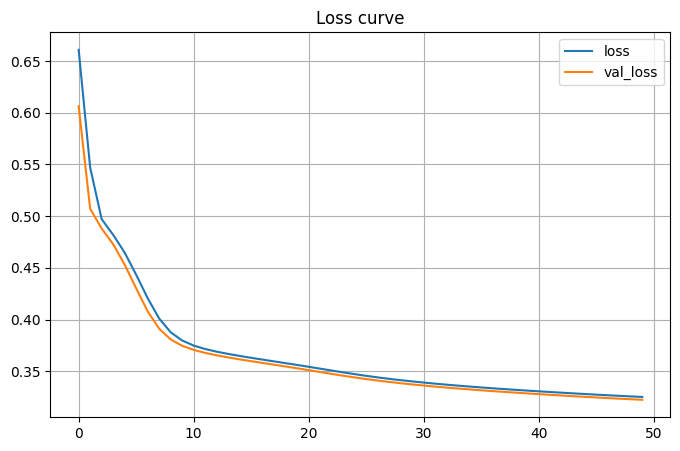

In [5]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Loss curve')
#plt.savefig('/kaggle/working/loss.png')
plt.show()

1/1 [==============================] - 0s 139ms/step


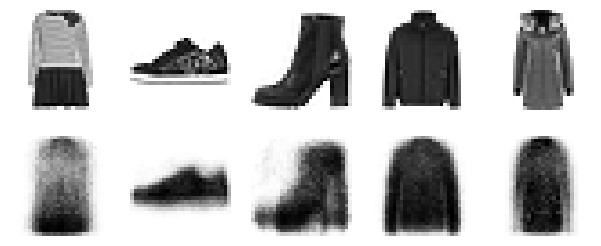

In [6]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructoins(model, n_images=5):
    random_indexs = np.random.choice(np.arange(len(X_valid)), size=n_images, replace=False)
    reconstructions = model.predict(X_valid[random_indexs])
    #reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[random_indexs[image_index]])
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructoins(stacked_ae)

In [7]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


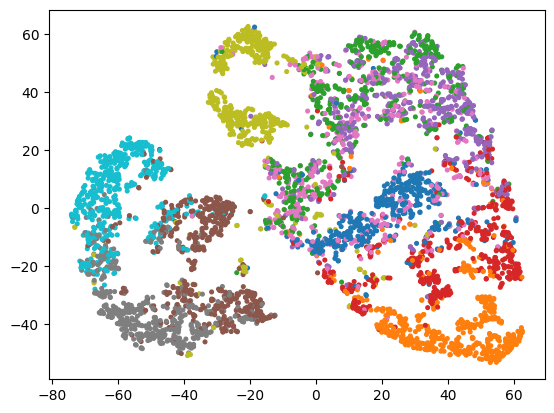

In [8]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=7, cmap='tab10')

<h3>Convolutional Autoencoder</h3>

In [9]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                activation='selu',
                                input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.5655 - val_loss: 0.4384
Epoch 2/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3918 - val_loss: 0.3678
Epoch 3/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3602 - val_loss: 0.3487
Epoch 4/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3451 - val_loss: 0.3366
Epoch 5/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3353 - val_loss: 0.3285
Epoch 6/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3283 - val_loss: 0.3224
Epoch 7/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3230 - val_loss: 0.3177
Epoch 8/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3186 - val_loss: 0.3137
Epoch 9/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3150 - val_loss: 0.3104
Epoch 10/10
1719/1719 [==============================] - 39s 23m

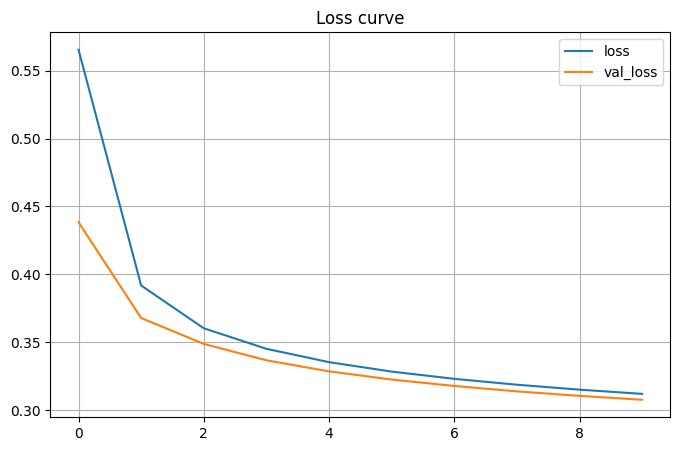

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Loss curve')
#plt.savefig('/kaggle/working/loss.png')
plt.show()

1/1 [==============================] - 0s 149ms/step


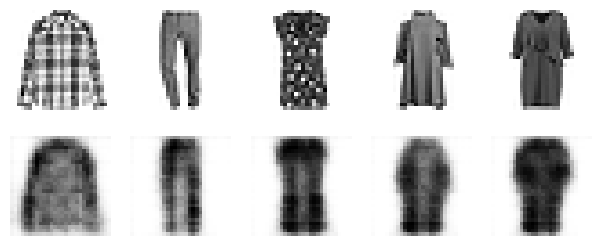

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructoins(model, n_images=5):
    random_indexs = np.random.choice(np.arange(len(X_valid)), size=n_images, replace=False)
    reconstructions = model.predict(X_valid[random_indexs])
    #reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[random_indexs[image_index]])
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructoins(conv_ae)

<h3>Variational Autoencoder</h3>

In [12]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2)  + mean

In [13]:
codings_size = 10
    
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs],
                                 outputs=[codings_mean, codings_log_var, codings])
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs],
                                 outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,
                            validation_data=[X_valid, X_valid])

Epoch 1/50
430/430 [==============================] - 7s 13ms/step - loss: 0.4148 - val_loss: 0.3615
Epoch 2/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3561 - val_loss: 0.3488
Epoch 3/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3447 - val_loss: 0.3412
Epoch 4/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3381 - val_loss: 0.3322
Epoch 5/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3334 - val_loss: 0.3269
Epoch 6/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3303 - val_loss: 0.3262
Epoch 7/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3279 - val_loss: 0.3263
Epoch 8/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3261 - val_loss: 0.3226
Epoch 9/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3247 - val_loss: 0.3216
Epoch 10/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3235 - val_lo

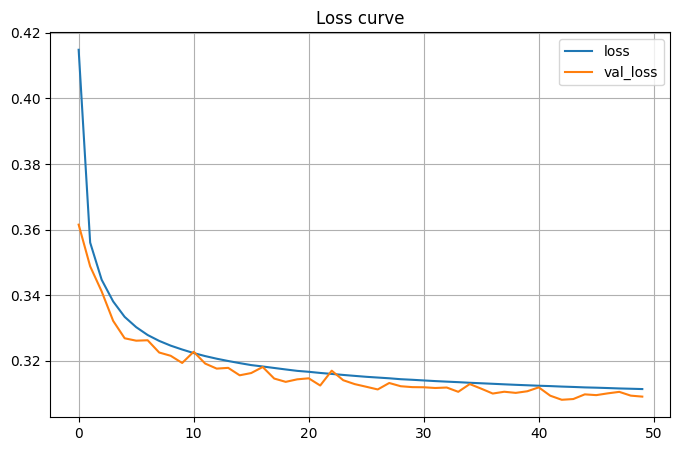

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Loss curve')
#plt.savefig('/kaggle/working/loss.png')
plt.show()

In [15]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings)
images = tf.convert_to_tensor(images)

In [16]:
type(images)

keras.src.engine.keras_tensor.KerasTensor

In [17]:
images.shape

TensorShape([35, 28, 28])